#<h1 align="center"><font color=#b00020><b>Detecting Money Laundering Activities on Crypto Exchanges - Muhammad Najati Alimam - DEDA_SoSe_2021</b></font></h1>

#<h2 align="left"><font color=#2196F3>Introduction</h2>

<b>Content</b>
<p>
This anonymized data set is a transaction graph collected from the Bitcoin blockchain. A node in the graph represents a transaction, an edge can be viewed as a flow of Bitcoins between one transaction and the other. Each node has 166 features and has been labeled as being created by a "licit", "illicit" or "unknown" entity.
</p>

<b>Nodes and edges</b>
<p>
The graph is made of 203,769 nodes and 234,355 edges. Two percent (4,545) of the nodes are labelled class1 (illicit). Twenty-one percent (42,019) are labelled class2 (licit). The remaining transactions are not labelled with regard to licit versus illicit.
</p>

<b>Features</b>
<p>
There are 166 features associated with each node. Due to intellectual property issues, we cannot provide an exact description of all the features in the dataset. There is a time step associated to each node, representing a measure of the time when a transaction was broadcasted to the Bitcoin network. The time steps, running from 1 to 49, are evenly spaced with an interval of about two weeks. Each time step contains a single connected component of transactions that appeared on the blockchain within less than three hours between each other; there are no edges connecting the different time steps.
</p>

<p>
The first 94 features represent local information about the transaction – including the time step described above, number of inputs/outputs, transaction fee, output volume and aggregated figures such as average BTC received (spent) by the inputs/outputs and average number of incoming (outgoing) transactions associated with the inputs/outputs. The remaining 72 features are aggregated features, obtained using transaction information one-hop backward/forward from the center node - giving the maximum, minimum, standard deviation and correlation coefficients of the neighbour transactions for the same information data (number of inputs/outputs, transaction fee, etc.).
</p>


<b>License</b>
<p>
This data set is distributed under the Creative CommonsAttribution-NonCommercial-NoDerivatives License 4.0 International.

<p>Summary</p>
<ul>
<li>Licit: exchanges, wallet providers, miners, licit services, etc.
<li>Ilicit: scams, malware, terrorist, organization, ransomware, Ponzi shcemes, etc. A given transaction is licit if the entity that generated it was licit.

<li>Nodes and Edges: 203,769 node transactions and 234,355 directed edge payments flows. 2% are ilicit (Class 1), 21% are licit (Class 2)
<li>Features: Each node has associated 166 features. 94 represent local information (timestep, number of inputs/outputs, transaction fee, output volume and aggregated figures) and 72 features represent aggregated features (obtained by aggregating transaction information such as maximum, minimum, standard deviation, correlation coefficients of neighbor transactions).
<li>Temporal Information: A time step is associated with each node, representing an stimated of the time when the transaction is confirmed. There are 49 distinct timesteps evenly spaced with an interval of 2 weeks.
<li>elliptic_txs_edgelist.csv contains graph edges information;
<li>elliptic_txs_classes.csv contains information about legality of transactions;
<li>elliptic_txs_features.csv contains information about transaction features;

#<h2 align="left"><font color=#2196F3>Setting Path</h2>

In [1]:
# Create a global variable to idicate whether the notebook is run in Colab
import sys
import os

IN_COLAB = 'google.colab' in sys.modules

# Configure variables pointing to directories and stored files 
if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/gdrive')
  os.chdir('/content/gdrive/My Drive/DEDA')
  print(os.getcwd())
  !ls
else:
  print('Please select your local path (place datasets in same folder like notebook)')
  os.chdir(r"C:\Users\YourPath")
  !ls

Mounted at /content/gdrive
/content/gdrive/My Drive/DEDA
'AML - Bitcoin.ipynb'				  elliptic_txs_edgelist.csv
'Detecting Cryptocurrency Money Laundering.key'   elliptic_txs_features.csv
 elliptic_txs_classes.csv



#<h2 align="left"><font color=#2196F3>Importing General Use Libraries</h2>

In [2]:
from pathlib import Path
import math
import pandas as pd
import numpy as np
import pickle
from pprint import pprint

from sklearn import metrics
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots

pd.options.mode.chained_assignment = None  # removes warning messages
#pd.set_option('display.max_rows', None)

# Setting seed for results to be re-producable
np.random.seed(666)

#<h2 align="left"><font color=#2196F3>Loading Datasets - Visualisation - Merging</h2>

In [3]:
main_classes = pd.read_csv('elliptic_txs_classes.csv')
main_edgelist = pd.read_csv('elliptic_txs_edgelist.csv')
main_features = pd.read_csv('elliptic_txs_features.csv', header=None)

In [4]:
#change class unknown to 3
main_classes.loc[main_classes['class'] == 'unknown', 'class'] = 3

In [5]:
main_classes['class'].value_counts()

3    157205
2     42019
1      4545
Name: class, dtype: int64

<BarContainer object of 3 artists>

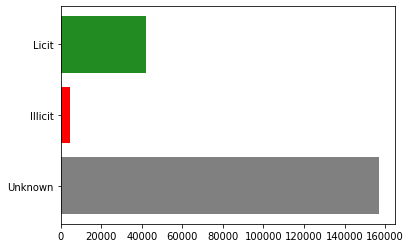

In [6]:
group_class = main_classes.groupby('class').count()
plt.barh(['Unknown', 'Illicit', 'Licit'], group_class['txId'].values, color=['grey', 'red', 'forestgreen'] )

Class 1 means that transaction is illicit, '2' means that transaction is licit and most transaction aren't labeled.

In [7]:
# renaming columns
main_features.columns = ['txId', 'time step'] + [f'local_feat_{i}' for i in range(93)] + [f'agg_feat_{i}' for i in range(72)]

In [8]:
# merge with classes
main_combined = pd.merge(main_features, main_classes, left_on='txId', right_on='txId', how='left')

First we pick the class 1 or 2 transactions only

In [9]:
selected_ids = main_combined.loc[(main_combined['class'] != 3), 'txId']
main_edges_selected = main_edgelist.loc[main_edgelist['txId1'].isin(selected_ids)]
main_classes_selected = main_classes.loc[main_classes['txId'].isin(selected_ids)]
main_features_selected = main_features.loc[main_features['txId'].isin(selected_ids)]

# Merge Class and features
main_combined_selected = pd.merge(main_classes_selected, main_features_selected )
main_combined_selected.head()

,txId,class,time step,local_feat_0,local_feat_1,local_feat_2,local_feat_3,local_feat_4,local_feat_5,local_feat_6,local_feat_7,local_feat_8,local_feat_9,local_feat_10,local_feat_11,local_feat_12,local_feat_13,local_feat_14,local_feat_15,local_feat_16,local_feat_17,local_feat_18,local_feat_19,local_feat_20,local_feat_21,local_feat_22,local_feat_23,local_feat_24,local_feat_25,local_feat_26,local_feat_27,local_feat_28,local_feat_29,local_feat_30,local_feat_31,local_feat_32,local_feat_33,local_feat_34,local_feat_35,local_feat_36,...,agg_feat_32,agg_feat_33,agg_feat_34,agg_feat_35,agg_feat_36,agg_feat_37,agg_feat_38,agg_feat_39,agg_feat_40,agg_feat_41,agg_feat_42,agg_feat_43,agg_feat_44,agg_feat_45,agg_feat_46,agg_feat_47,agg_feat_48,agg_feat_49,agg_feat_50,agg_feat_51,agg_feat_52,agg_feat_53,agg_feat_54,agg_feat_55,agg_feat_56,agg_feat_57,agg_feat_58,agg_feat_59,agg_feat_60,agg_feat_61,agg_feat_62,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71
0,232438397,2,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,-0.115831,0.043598,-0.163905,1.059993,2.397457,-0.063200,-0.013282,4.800240,0.174329,-0.172908,0.619399,-0.243300,-0.243452,-0.139732,-0.146895,-0.079667,-0.155554,0.773847,0.378516,-0.139734,-0.146891,-0.079667,-0.155553,0.773932,0.378593,-0.024669,-0.031271,-0.023044,-0.026215,...,0.019771,-0.119195,0.147881,0.956170,0.759756,-0.041556,-0.188716,0.149949,-0.047722,-0.048171,-1.373723,-1.356131,-0.301754,-1.404445,0.183133,0.182748,-0.163577,-0.456561,-0.424672,-0.436915,0.143001,0.142525,-0.425896,-1.421138,-1.059868,-1.071885,0.185597,0.185492,-0.216814,-0.617907,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
1,232029206,2,1,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,-0.163645,-0.144554,0.020069,-0.163135,1.696691,2.414968,-0.063200,-0.013282,2.370512,0.001525,-0.172908,0.221419,-0.243300,-0.243452,-0.139732,-0.147416,-0.079747,-0.155559,0.665165,1.037078,-0.139734,-0.147411,-0.079746,-0.155559,0.665251,1.037113,-0.024669,-0.031272,-0.023045,-0.026215,...,-0.086194,-0.124629,0.525309,0.617474,0.317264,-0.121020,-0.188716,-0.032710,-0.047722,-0.048171,-1.373902,-1.356289,-0.301754,-1.404621,0.183133,0.182748,-0.163577,-0.456561,-0.424672,-0.436915,0.143001,0.142525,-0.425896,-1.421138,-1.059868,-1.071885,0.185597,0.185492,-0.216814,-0.617907,-0.577099,-0.613614,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792
2,232344069,2,1,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.137933,-0.144108,-0.049707,-0.140266,-0.028741,-0.035391,-0.042955,-0.013282,-0.006754,-0.148916,-0.151494,-0.146513,0.887058,0.884557,-0.139721,-0.148905,-0.080147,-0.155653,-0.010763,-0.012107,-0.139723,-0.148901,-0.080147,-0.155653,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,...,-0.097719,-0.127462,0.003143,0.002426,-0.115680,-0.190199,-0.177836,-0.201578,1.064205,1.063787,-1.373932,-1.356183,-0.301411,-1.404577,-0.975738,-0.975237,-0.168742,-0.445357,-0.409015,-0.427594,-1.015963,-1.016230,-0.968903,-1.943850,-1.059868,-1.678997,0.185597,0.185492,-0.216814,-0.617907,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
3,27553029,2,1,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.141519,-0.147643,-0.049707,-0.143847,-0.028741,-0.035391,-0.042955,-0.013282,-0.038424,-0.150266,-0.150457,-0.150661,0.887058,0.884557,-0.139722,-0.148906,-0.080147,-0.155654,-0.010763,-0.012107,-0.139724,-0.148902,-0.080147,-0.155654,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,...,-0.097719,-0.127462,0.003143,0.002426,-0.107516,-0.190820,-0.180486,-0.200607,1.064205,1.063787,-1.373902,-1.348835,-0.282308,-1.400475,-0.975738,-0.975237,-0.168742,-0.454961,-0.420758,-0.436915,-1.015963,-1.016230,-0.968903,-1.943850,-1.059868,-1.678997,0.185597,0.185492,-0.216814,-0.587217,-0.

In [10]:
X = main_combined_selected.drop(columns=['txId', 'class', 'time step']) # drop class, text id and time step
y = main_combined_selected[['class']]

# in this case, class 2 corresponds to licit transactions, we chang this to 0 as our interest is the ilicit transactions
y = y['class'].apply(lambda x: 0 if x == '2' else 1 ) 

#<h2 align="left"><font color=#2196F3>Split</h2>

In [11]:
from sklearn.model_selection import train_test_split

Split train/test data. By test here I mean validation.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=666) # A random state is assigned for results to be repeatable

#<h2 align="left"><font color=#2196F3>Random Forest Classifier</h2>

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, roc_curve, f1_score, auc
from sklearn.metrics import plot_roc_curve

In [32]:
rfc = RandomForestClassifier().fit(X_train,y_train)
rfc_predict = rfc.predict(X_test)

In [33]:
prec,rec,f1,num = precision_recall_fscore_support(y_test, rfc_predict)
print("Random Forest Classifier")
print("Precision:%.3f \nRecall:%.3f \nF1 Score:%.3f"%(prec[1],rec[1],f1[1]))

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rfc_predict))
print('\n')
print("=== AUC Score ===")
rfc_predict = rfc.predict_proba(X_test)[:,1]
print(metrics.roc_auc_score(y_test,rfc_predict))


Random Forest Classifier
Precision:0.995 
Recall:0.908 
F1 Score:0.950
=== Confusion Matrix ===
[[10429     5]
 [  111  1096]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     10434
           1       1.00      0.91      0.95      1207

    accuracy                           0.99     11641
   macro avg       0.99      0.95      0.97     11641
weighted avg       0.99      0.99      0.99     11641



=== AUC Score ===
0.995366622946873


#<h2 align="left"><font color=#2196F3>RF - Hyperparameter Tuning</h2>

In [ ]:
# Hyperparameter tuning for all models was not performed in this notebook due to time constraint
# but a sample on how to tune a RF model using Randomized Search is found below

In [ ]:
pprint(rfc.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1500, num = 4)]
# Number of features to consider at every split
max_features = [5, 10, 15]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [5, 10, 30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,}
pprint(random_grid)

{'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': [5, 10, 15],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [5, 10, 30],
 'n_estimators': [200, 633, 1066, 1500]}


In [ ]:
%%time
###### WARNING: this might take a really long time depending on your CPU
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rfc_tuning = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 50 different combinations, and use all available cores
rfc_tuning_random = RandomizedSearchCV(estimator = rfc_tuning, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=1, random_state=666, n_jobs = -1)
# Fit the random search model
rfc_tuning_random.fit(X_train,y_train)
rfc_tuning_random_predict = rfc_tuning_random.predict(X_test)

prec,rec,f1,num = precision_recall_fscore_support(y_test, rfc_tuning_random_predict)

print("Random Forest Classifier")
print("Precision:%.3f \nRecall:%.3f \nF1 Score:%.3f"%(prec[1],rec[1],f1[1]))

#<h2 align="left"><font color=#2196F3>XGBoost</h2>

In [19]:
from xgboost import XGBClassifier

In [20]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
xgb_predict = xgb_model.predict(X_test)

In [21]:
# XGBoost AUC score shows a different number from sklearn's roc_auc_score, find out why: https://github.com/dmlc/xgboost/issues/2064
# A small clarification of the above: https://discuss.analyticsvidhya.com/t/what-is-the-difference-between-predict-and-predict-proba/67376/3
prec,rec,f1,num = precision_recall_fscore_support(y_test, xgb_predict)
print("XGBoost Classifier")
print("Precision:%.3f \nRecall:%.3f \nF1 Score:%.3f"%(prec[1],rec[1],f1[1]))

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, xgb_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, xgb_predict))
print('\n')
print("=== AUC Score ===")
xgb_predict = xgb_model.predict_proba(X_test)[:,1]
print(metrics.roc_auc_score(y_test,xgb_predict))

XGBoost Classifier
Precision:0.989 
Recall:0.882 
F1 Score:0.932
=== Confusion Matrix ===
[[10422    12]
 [  143  1064]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     10434
           1       0.99      0.88      0.93      1207

    accuracy                           0.99     11641
   macro avg       0.99      0.94      0.96     11641
weighted avg       0.99      0.99      0.99     11641



=== AUC Score ===
0.9944122276306873


#<h2 align="left"><font color=#2196F3>XGBoost - Hyperparameter Tuning</h2>

In [22]:
# After finding the best parameters (which was not done in this notebook due to time constraints)
# Aguide to do that can be found here: https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f
# For now, we will pretend to have found the optimal parameters and set them manually.
xgb_tuned_model = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.5,
                      subsample = 1,
                      objective='binary:logistic', 
                      n_estimators=1000, 
                      reg_alpha = 0.3,
                      max_depth=5, 
                      gamma=10)

In [23]:
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["auc"]
xgb_tuned_model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=10,
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=False, subsample=1, verbosity=1)

In [24]:
xgb_tuned_model_predict = xgb_tuned_model.predict(X_test)

In [25]:
prec,rec,f1,num = precision_recall_fscore_support(y_test, xgb_tuned_model_predict)
print("XGBoost Classifier")
print("Precision:%.3f \nRecall:%.3f \nF1 Score:%.3f"%(prec[1],rec[1],f1[1]))

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, xgb_tuned_model_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, xgb_tuned_model_predict))
print('\n')
print("=== AUC Score ===")
xgb_tuned_model_predict = xgb_tuned_model.predict_proba(X_test)[:,1]
print(metrics.roc_auc_score(y_test,xgb_tuned_model_predict))

XGBoost Classifier
Precision:0.992 
Recall:0.911 
F1 Score:0.950
=== Confusion Matrix ===
[[10425     9]
 [  107  1100]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     10434
           1       0.99      0.91      0.95      1207

    accuracy                           0.99     11641
   macro avg       0.99      0.96      0.97     11641
weighted avg       0.99      0.99      0.99     11641



=== AUC Score ===
0.9962005228271159


#<h2 align="left"><font color=#2196F3>Feed Foward Neural Network</h2>

In [26]:
#from tensorflow import keras # instead of importing the whole framework, we can import individual modules that we need
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.layers import concatenate
from keras.layers import Input

#regularization
from keras.layers import Dropout
from keras import regularizers

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(34923, 165) (11641, 165) (34923,) (11641,)


In [27]:
# define and fit the model
def get_model(X_train, y_train):
	# define model
  nn_model = Sequential()
  nn_model.add(Dense(150, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01), bias_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01), input_shape=(165,)))
  nn_model.add(Dropout(0.20))
  nn_model.add(Dense(50, activation='relu'))
  nn_model.add(Dropout(0.20))
  nn_model.add(Dense(10, activation='relu'))
  nn_model.add(Dense(1, activation='sigmoid'))
	# compile model
  nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit model
  nn_model.fit(X_train, y_train, epochs=10, batch_size=10, verbose=1)
  return nn_model

In [28]:
%%time
nn_model = get_model(X_train, y_train)

Epoch 1/10
3493/3493 [==============================] - 24s 2ms/step - loss: 1.8521 - accuracy: 0.8996
Epoch 2/10
3493/3493 [==============================] - 8s 2ms/step - loss: 0.3974 - accuracy: 0.9420
Epoch 3/10
3493/3493 [==============================] - 8s 2ms/step - loss: 0.3794 - accuracy: 0.9480
Epoch 4/10
3493/3493 [==============================] - 8s 2ms/step - loss: 0.4001 - accuracy: 0.9485
Epoch 5/10
3493/3493 [==============================] - 8s 2ms/step - loss: 0.4065 - accuracy: 0.9473
Epoch 6/10
3493/3493 [==============================] - 8s 2ms/step - loss: 0.3956 - accuracy: 0.9486
Epoch 7/10
3493/3493 [==============================] - 8s 2ms/step - loss: 0.4219 - accuracy: 0.9467
Epoch 8/10
3493/3493 [==============================] - 8s 2ms/step - loss: 0.4112 - accuracy: 0.9491
Epoch 9/10
3493/3493 [==============================] - 8s 2ms/step - loss: 0.4443 - accuracy: 0.9473
Epoch 10/10
3493/3493 [==============================] - 8s 2ms/step - loss: 0.44

In [29]:
# predict probabilities for test set
yhat_probs = nn_model.predict(X_test, verbose=0)
# predict crisp classes for test set
yhat_classes = nn_model.predict_classes(X_test, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]
 
#  accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning:

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).



Accuracy: 0.928013
Precision: 0.934118
Recall: 0.328915
F1 score: 0.486520


#<h2 align="left"><font color=#2196F3>Plotting ROC</h2>

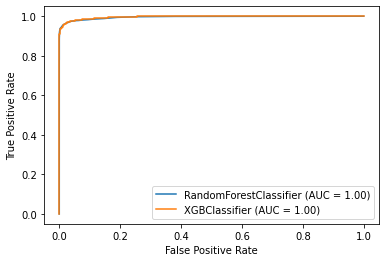

In [37]:
# RF and XGBoost

classifiers = [rfc, xgb_tuned_model]
ax = plt.gca()
for i in classifiers:
    plot_roc_curve(i, X_test, y_test, ax=ax)

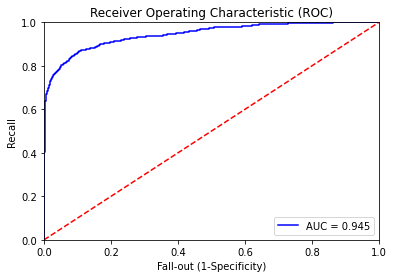

In [ ]:
# Neural Network
false_positive_rate, recall, thresholds = roc_curve(y_test, predictions_NN_prob)
roc_auc = auc(false_positive_rate, recall)
plt.figure()
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

#<h2 align="left"><font color=#2196F3>Sources</h2>

sources
<ul>
<li>https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74<li>https://github.com/WillKoehrsen/Machine-Learning-Projects/blob/master/random_forest_explained/.ipynb_checkpoints/Improving%20Random%20Forest%20Part%202-checkpoint.ipynb
<li>https://www.kaggle.com/artgor/elliptic-data-eda
<li>https://www.kaggle.com/smlopezza/elliptic-data-set-eda-graphs-random-forest
<li> https://www.kaggle.com/georsara1/95-auc-score-in-train-sample-with-neural-nets</li>
<li>https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e</li>
</ul>
A lot of research was done. I have probably missed some resources, but they all relate to code and code optimization. Please refer to the slides for a more comprehensive source citation

#<h1 align="center"><font color=#b00020><b>Thank You</b></font></h1>